In [ ]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=939c0a9a7e2ea49f93bf28b6b89016d11a9bed371f2411b709a90bdc944c2d64
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [1]:
import re

# Separar tarjetas graficas integradas y no integradas
# Probar one hot instead of ordinal
# Opcion para polinomicas
# Opcion para cv test

########################
# Handlers de columnas #
########################

# Sort from lower to higher so that the lowest is 0 and the highest is n
def sortColumnByPriceAverage(X, columnName):
  companies = {}

  for product in X[columnName]:
    companies[product] = (0, 0)

  for i, company in enumerate(X[columnName]):
    price = X["Price"][i]
    val, n = companies[company]
    val += price

    companies[company] = (val, n+1)

  _companies = [ (company, companies[company][0]) for company in companies ]
  sortedCompanies = list(map(lambda t: t[0], sorted(_companies, key=lambda t: t[1])))

  return sortedCompanies

###########
# Product #
###########

def handle_product_series(row):
  product = row["Product"]

  if " " in product and "(" not in product:
    return product.split()[0].strip()
  elif "-" in product:
    return product.split("-")[0].strip()

def handle_product_subseries(row):
  product = row["Product"]
  series = handle_product_series(row)

  if not series:
    return ""
  else:
    subseries = product.replace(series, "")

    if "(" in subseries:
      subseries = subseries.split("(")[0]
    
    if subseries.startswith("-"):
      subseries = subseries[1:]

    return subseries.strip()

##########
# Screen #
##########

def handle_screen_pixels(row):
  resolution = re.findall("\d+x\d+", row["ScreenResolution"])[0]
  w, h = [ int(_) for _ in resolution.split("x") ] # Ancho y alto

  return w*h

def handle_screen_ratio(row):
  resolution = re.findall("\d+x\d+", row["ScreenResolution"])[0]
  w, h = [ int(_) for _ in resolution.split("x") ] # Ancho y alto

  ratios = {
      (1366, 768): "16:9",
      (1440, 900): "16:10",
      (1600, 900): "16:9",
      (1920, 1080): "16:9",
      (1920, 1200): "16:10",
      (2160, 1440): "3:2",
      (2256, 1504): "3:2",
      (2304, 1440): "16:10",
      (2400, 1600): "3:2",
      (2560, 1440): "16:9",
      (2560, 1600): "16:10",
      (2736, 1824): "3:2",
      (2880, 1800): "16:10",
      (3200, 1800): "16:9",
      (3840, 2160): "16:9",
  }

  if (w, h) in ratios:
    return ratios[(w, h)]
  else:
    print("Ratio doesnt exist", (w, h))
    return 0

def handle_is_screen_ips(row):
  return "ips" in row["ScreenResolution"]

def handle_has_touchscreen(row):
  res = row["ScreenResolution"]
  return "touchscreen" in res

#######
# CPU #
#######

def handle_cpu_speed(row):
  return float( row["Cpu"].split()[-1][:-3] )

def parse_cpu(row):
  #return row["Cpu"].split()[1]
  amd_regex = "amd[^\d]+"
  intel_regex = "intel[^\d]+(?:\d[\s-])?"
  samsung_regex = "samsung[\w\s]+"

  res = re.findall(amd_regex+"|"+intel_regex+"|"+samsung_regex, row["Cpu"])

  if res:
    res = res[0]
    if res[-1] == "-": res = res[:-1] # Quitar - al final
    
    return res.strip()
  else:
    print("CPU not found")
    return ""

def handle_cpu_brand(row):
  cpu = parse_cpu(row)

  return cpu.split()[0].strip()

def handle_cpu_model(row):
  cpu = parse_cpu(row)
  brand = handle_cpu_brand(row)

  return cpu.replace(brand, "").strip()

def handle_cpu_submodel(row):
  cpu = row["Cpu"]
  brand = handle_cpu_brand(row)
  model = handle_cpu_model(row)

  submodel = cpu.replace(brand, "").replace(model, "").strip().split()[0].strip()

  if submodel[0] == "-":
    submodel = submodel[1:]
  
  return submodel

def handle_cpu_antiguedad(row):
  model = parse_gpu(row)
  model_number = row["Cpu"].replace(model, "").strip() # El numero es lo que se queda al quitarle el modelo

  n = re.findall("(\d{4})", model_number) # Obtener el numero

  return n

#######
# GPU #
#######

def parse_gpu(row):
  regex_amd = "amd (?:firepro|r\d|radeon (?:r\d?\w?)?)"
  regex_arm = "arm mali"
  regex_intel = "intel [^\d]*"
  regex_nvidia = "nvidia (?:quadro|(?:geforce)?\s?)"

  res = re.findall(regex_amd+"|"+regex_arm+"|"+regex_intel+"|"+regex_nvidia, row["Gpu"])

  if res:
    return res[0].strip()
  else:
    print("Model not found", row["Gpu"], res)
    return ""

def handle_gpu_brand(row):
  model = parse_gpu(row)
  return model.split()[0]

def handle_gpu_model_number(row):
  model = parse_gpu(row)
  model_number = row["Gpu"].replace(model, "").strip() # El numero es lo que se queda al quitarle el modelo

  n = re.findall("\d+", model_number) # Obtener el numero

  if not n:
    return 2 # No lo ha encontrado o no lo tiene. Si pongo 0 aumenta. Puede ser overfitting.
  else:
    return int(n[0].strip())

def handle_gpu_model(row):
  model = parse_gpu(row)
  brand = handle_gpu_brand(row)

  #print(model, brand, model.replace(brand, ""))

  return model.replace(brand, "").strip() # El espacio al principio

def handle_gpu_model_gama(row):
  model = parse_gpu(row)
  model_number = row["Gpu"].replace(model, "").strip() # El numero es lo que se queda al quitarle el modelo

  n = re.findall("\d+", model_number) # Obtener el numero

  if not n:
    return "Indeterminada" # No lo ha encontrado o no lo tiene. Si pongo 0 aumenta. Puede ser overfitting.
  else:
    #"Muy Alta" if int(n[0].strip()) > 1000 else 
    return "Alta" if int(n[0].strip()) > 700 else "Media" if int(n[0].strip()) > 500 else "Baja"

###########
# Storage #
###########

def parse_memory(mem):
   regex_memoria = "(\d*\.?\d+)(\w+) (SSD|HDD|Flash Storage|Hybrid)" # Regex para identificar la memoria
   return [ x for x in re.findall(regex_memoria, mem) ] # Lista con tuplas de todos los discos encontrados

def handle_storage_capacity(row):
  productos = parse_memory(row["Memory"])
  capacity = sum([
      float(producto[0]) * (1000 if producto[1] == "TB" else 1) for producto in productos
  ])

  return capacity

def handle_has_disc(row, discType):
  productos = parse_memory(row["Memory"])
  return any([ producto[2] == discType for producto in productos ])

def handle_n_discs(row, discType):
  productos = parse_memory(row["Memory"])
  return len([ producto[2] == discType for producto in productos ])

######
# OS #
######

def handle_is_os_free(row):
  return row["OpSys"] in ["No OS", "Linux"] # Cambiar


In [2]:
#@title  { form-width: "400px", vertical-output: true}
import pandas as pd
import numpy as np
import re
import random
from copy import deepcopy
import statistics as stat
import sklearn.compose
from sklearn.linear_model import ElasticNet
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV

##########
# Modelo #
##########
class Model:
  def __init__(self, alpha, ratio):
    #csv sucios
    #self.TRAIN_URL = "https://filebin.net/3sw6utbuul0sh225/train.csv" #csv sucio
    #self.TEST_URL  = "https://filebin.net/3sw6utbuul0sh225/test.csv" # csv limpio

    # csv limpios (TODO: Company)
    self.TRAIN_URL = "https://filebin.net/gaefio7cpujn0e9x/train_clean.csv"
    self.TEST_URL = "https://filebin.net/gaefio7cpujn0e9x/test_clean.csv"

    self.alpha = alpha
    self.ratio = ratio

    self.X = None
    self.Y = None
    self.X_T = None
    self.Y_T = None

    self.trained_model = None
    self.prediction = None
    self.csv = None

    self.pipe = None # El conjunto de regresores que se aplican

    self.X_original = None
    self.X_final = None

  ###########
  # Dataset #
  ###########
  def load_datasets(self):
    self.X = pd.read_csv(self.TRAIN_URL, sep=",")
    self.Y = pd.read_csv(self.TEST_URL,  sep=",")
    
    # Mantener una copia para echarle un vistazo
    self.X_original = self.X.copy(deep=True)
    self.Y_original = self.X.copy(deep=True)
  
  ##############################
  # Transformacion de columnas #
  ##############################
  # Aplica la funcion f a todos los elementos de una columna
  def map_column(self, columna, f):
    self.X[columna] = [ f(val) for val in self.X[columna] ]
    self.Y[columna] = [ f(val) for val in self.Y[columna] ]
  
  def add_column(self, columna, f):
    self.X[columna] = self.X.apply(lambda row: f(row), axis=1)
    self.Y[columna] = self.Y.apply(lambda row: f(row), axis=1)

  # Modifica los valores de cada columna. Se pueden comentar y no pasa nada.
  def modify_columns(self):
    self.add_column("Series", handle_product_series)
    self.add_column("Subseries", handle_product_subseries)
    self.add_column("StorageCapacity", handle_storage_capacity)
    self.add_column("HasHHD", lambda row: handle_has_disc(row, "SSD"))
    self.add_column("HasSSD", lambda row: handle_has_disc(row, "HDD"))
    self.add_column("HasHybrid", lambda row: handle_has_disc(row, "Hybrid"))
    self.add_column("HasFlashStorage", lambda row: handle_has_disc(row, "Flash Storage"))
    self.add_column("ScreenPixels", handle_screen_pixels)
    self.add_column("ScreenRatio", handle_screen_ratio)
    self.add_column("IsScreenIPS", handle_is_screen_ips)
    self.add_column("HasTouchscreen", handle_has_touchscreen)
    self.add_column("IsOSFree", handle_is_os_free)
    self.add_column("CPUBrand", handle_cpu_brand)
    self.add_column("CPUModel", handle_cpu_model)
    self.add_column("CPUSubmodel", handle_cpu_submodel)
    self.add_column("CPUSpeed", handle_cpu_speed)
    #self.add_column("CPUModelAntiguedad", handle_cpu_antiguedad)
    self.add_column("GPUBrand", handle_gpu_brand)
    self.add_column("GPUModel", handle_gpu_model)
    self.add_column("GPUModelNumber", handle_gpu_model_number)
    self.add_column("GPUModelGama", handle_gpu_model_gama)

    self.map_column("Ram",              lambda val: int(val[:-2]))
    self.map_column("Weight",           lambda val: float(val[:-2]))

    # Another X for consulting and visualization
    self.X_final = self.X.copy(deep=True)\
      .drop(["Product", "OpSys", "Company", "ScreenResolution", "Cpu", "Gpu", "Memory"], axis=1)

  def transform_datasets(self):
    categoriesCPUBrand = [
        'intel pentium dual core', 'intel pentium dual core n', 'intel pentium quad core n',
        'intel celeron dual core', 'intel celeron dual core n', 'intel celeron quad core n',
        'amd e', 'amd a',
        'intel xeon e3', 'samsung cortex a72', 'intel atom x5', 
        'intel core m', 'intel core m m3', 'intel core m m7',
        'intel core i3', 'intel core i5', 'amd fx', 'amd ryzen', 'intel core i7'
    ]

    sortedOS = ["No OS", "Linux", "Android", "Chrome OS", "Windows 10 S", "Windows 7", "Windows 10", "macOS", "Mac OS X"]

    categoriesTN = [ 'netbook', 'ultrabook', '2 in 1 convertible', 'notebook', 'gaming', 'workstation' ]

    #categoriesCompany = [ 'Mediacom', 'Chuwi', 'Google', 'Vero', 'Fujitsu', 'Toshiba', 'Xiaomi', 'Huawei', 'Lenovo', 
    #                      'LG', 'Samsung', 'Acer',  'HP', 'Microsoft', 'Asus', 'Dell', 'MSI','Apple', 'Razer' ]

    categoriesRatios = [ "3:2", "16:10", "16:9" ]

    categoriesGPUGama = ["Indeterminada", "Baja", "Media", "Alta"]

    pipeCPUBrand = Pipeline([
        ("encoder", OrdinalEncoder(categories=[categoriesCPUBrand])),
        ("scaler", StandardScaler())
    ])

    pipeGPUGama = Pipeline([
        ("encoder", OrdinalEncoder(categories=[categoriesGPUGama])),
        ("scaler", StandardScaler())
    ])

    pipeEncodeScale = Pipeline([
        ("encoder", OrdinalEncoder()),
        ("scaler", StandardScaler())
    ])

    testPipe = Pipeline([
        ("a", StandardScaler()),
        ("b", PolynomialFeatures(degree=3))
    ])

    test2Pipe = Pipeline([
        ("a", PolynomialFeatures(degree=3)),
        ("b", StandardScaler())
    ])
    
    ######
    # Para meterle todas las categorias de X e Y al OneHotEncoder.
    # Si no da problemas de shape porque X e Y tienen diferentes categorias.
    ######
    keysOpSys = list(set(self.X["OpSys"]).union(set(self.Y["OpSys"])))
    keysCompany = list(set(self.X["Company"]).union(set(self.Y["Company"])))
    keysTypeName = list(set(self.X["TypeName"]).union(set(self.Y["TypeName"])))
    keysCPUBrand = list(set(self.X["CPUBrand"]).union(set(self.Y["CPUBrand"])))
    keysCPUModel = list(set(self.X["CPUModel"]).union(set(self.Y["CPUModel"])))
    keysCPUSubmodel = list(set(self.X["CPUSubmodel"]).union(set(self.Y["CPUSubmodel"])))
    keysGPUBrand = list(set(self.X["GPUBrand"]).union(set(self.Y["GPUBrand"])))
    keysGPUModel = list(set(self.X["GPUModel"]).union(set(self.Y["GPUModel"])))
    keysSeries = list(set(self.X["Series"]).union(set(self.Y["Series"])))
    keysSubseries = list(set(self.X["Subseries"]).union(set(self.Y["Subseries"])))

    transformersX = [
        ("LaptopId",              "drop",                 [0]),
        ("Company",               OneHotEncoder(categories=[keysCompany]),        [1]),
        ("Product",               "drop",                 [2]),
        ("TypeName",              OneHotEncoder(categories=[keysTypeName]),        [3]),
        ("Inches",                StandardScaler(),       [4]),
        ("ScreenResolution",      "drop",                 [5]),
        ("Cpu",                   "drop",                 [6]),
        ("Ram",                   StandardScaler(),       [7]),
        ("Memory",                "drop",                 [8]),
        ("Gpu",                   "drop",                 [9]),
        ("OpSys",                 OneHotEncoder(categories=[keysOpSys]),        [10]),
        ("Weight",                StandardScaler(),       [11]),
        ("Price",                 "drop",                 [12]),

        # New Columns
        ("Series",                OneHotEncoder(categories=[keysSeries]),        [13]),
        ("SubSeries",             pipeEncodeScale,        [14]),
        ("StorageCapacity",       StandardScaler(),       [15]),
        ("HasHDD",                "passthrough",          [16]),
        ("HasSSD",                "passthrough",          [17]),
        ("HasHybrid",             "drop",          [18]),
        ("HasFlashStorage",       "passthrough",          [19]),
        ("ScreenPixels",          StandardScaler(),       [20]),
        ("ScreenRatio",           OneHotEncoder(),        [21]),
        ("IsScreenIPS",           "passthrough",          [22]),
        ("HasTouchscreen",        "passthrough",          [23]),
        ("IsOSFree",              "passthrough",          [24]),
        ("CPUBrand",              OneHotEncoder(categories=[keysCPUBrand]),           [25]),
        ("CPUModel",              OneHotEncoder(categories=[keysCPUModel]),           [26]),
        ("CPUSubmodel",              OneHotEncoder(categories=[keysCPUSubmodel]),           [27]),
        ("CPUSpeed",              StandardScaler(),       [28]),
        ("GPUBrand",              OneHotEncoder(categories=[keysGPUBrand]),        [29]),
        ("GPUModel",              OneHotEncoder(categories=[keysGPUModel]),        [30]),
        ("GPUModelNumber",        pipeEncodeScale,        [31]),
        ("GPUModelGama",          "drop",            [32])
    ]

    transformersY = deepcopy(transformersX)

    # Normbrar el orden de columnas de 0 a n-1
    transformersY.pop(12) # Eliminar precio
    for i, t in enumerate(transformersY): # Renumerar los indices de las columnas
      transformersY[i][2].pop()
      transformersY[i][2].append(i)

    self.X_T = sklearn.compose.ColumnTransformer(transformers=transformersX).fit_transform(self.X)
    self.Y_T = sklearn.compose.ColumnTransformer(transformers=transformersY).fit_transform(self.Y)

    # StandardScaler. No cambia mucho.
    #self.X_T = sklearn.preprocessing.StandardScaler().fit_transform(self.X_T)
    #self.Y_T = sklearn.preprocessing.StandardScaler().fit_transform(self.Y_T)
  
  ##########################
  # Regresion y prediccion #
  ##########################
  def set_pipe(self):
    max_features  = 48       #@param {type:"raw"}
    max_depth     = 50      #@param {type:"raw"}
    random_state  = 600738951   #@param {type:"raw"}

    pipe = Pipeline([#('poly', PolynomialFeatures(degree=1)),
                     #('standardscaler', StandardScaler()),
                     #('elasticnet',  ElasticNet(alpha=self.alpha, l1_ratio=self.ratio)),
                     #('sgd', SGDRegressor(max_iter=100, random_state=42)),
                     #('extratrees', ExtraTreesRegressor(n_estimators=40)),
                     ('randomforest', RandomForestRegressor(
                         criterion="absolute_error",
                         max_features=max_features,
                         max_depth=max_depth,
                         random_state=random_state))
    ])

    self.pipe = pipe

  def apply_regression(self):
    self.trained_model = self.pipe.fit(self.X_T, self.X["Price"])

  def predict(self):
    self.prediction = self.trained_model.predict(self.Y_T)

  #######
  # CSV #
  #######
  def to_csv(self):
    self.solucion = pd.DataFrame(data = {
        "LaptopId" : self.Y["LaptopId"],
        "Price"    : self.prediction
    })
  
  def save_csv(self, name):
    self.solucion.to_csv(name, index=False)

  #################
  # Ejecutar todo #
  #################
  def run(self):
    # Obtener y parsear datasets
    self.load_datasets()
    self.modify_columns()
    self.transform_datasets()

    # Aplicar regresion y hacer una prediccion
    self.set_pipe()
    self.apply_regression()
    self.predict()

    # Convertir a csv
    self.to_csv()
    self.save_csv("solucion.csv")
  
  def print_avgs(self):
    train_avg = sum(self.X["Price"]) / len(self.X["Price"])
    pred_avg  = sum(self.prediction) / len(self.prediction)

    print("Medias\n" + "-" * 100)
    print("Avg training set :", train_avg)
    print("Avg prediction   :", pred_avg)
    print("Diff             :", abs(train_avg - pred_avg), "\n")
    #print("\nScore:", self.trained_model.score()) TODO: FIX

  def print_stats(self):
    print("Intercept (precio basico):", self.prediction.intercept_)
    print("Coeficientes:", self.prediction.coef_)
    print("Correlaciones:", pd.DataFrame(data=np.expand_dims(self.prediction.coef_, axis=0), columns=self.model.X.feature_names))


############################
# Clase para probar el MAE #
############################
class ModelTest(Model):
  def __init__(self, alpha, ratio, partition_n):
    # Inicializar padre. Tiene que ser la primera llamada dentro del __init__
    super().__init__(alpha, ratio) 

    self.PARTITION_N = partition_n # Numero de particiones que se van a probar
    self.maes = None               # Array con los maes de cada intento

  def get_maes(self):
    # Prueba n particiones para training y validacion y devuelve el error obtenido en cada intento
    self.maes = cross_val_score(self.pipe, self.X_T, self.X["Price"],
                                cv=self.PARTITION_N, scoring="neg_mean_absolute_error")
    
  def grid_search(self):
    reg = RandomForestRegressor()

    clf = GridSearchCV(reg, scoring="neg_mean_absolute_error", cv=5, n_jobs=-1, param_grid={
        "criterion": ["absolute_error"],
        "random_state": [random.randint(0, 1000000000) for x in range(20)],
        "max_features": [x for x in range(15, 50)],
        "max_depth": [50]
        #"max_features": [x for x in range(5, 15)],
        #"max_depth": [40, 50, 100]
    })
    clf.fit(self.X_T, self.X["Price"])
    print(clf.cv_results_)
    print(clf.best_params_)

  def run(self):
    self.load_datasets()
    self.modify_columns()
    self.transform_datasets()
    self.set_pipe()
    #self.grid_search()
    self.get_maes()

  def print_MAE(self):
    print("MAEs    :", self.maes)
    print("MAE avg :", stat.mean(self.maes))
    print("MAE std :", stat.variance(self.maes)**(1/2))

def main():
  es_prueba = True   #@param {type:"boolean"}
  alpha = 0       
  ratio = 0         
  partition_n = 5    #@param {type:"slider", min:0, max:10,  step:1}

  if es_prueba:
    # Ejecutar para hacer pruebas
    model_test = ModelTest(alpha=alpha, ratio=ratio, partition_n=partition_n)
    model_test.run()
    model_test.print_MAE()

    return model_test

  else:
    # Ejecutar para guardar el resultado
    model = Model(alpha=alpha, ratio=ratio)
  
    model.run()
    model.print_avgs()
    #model.print_stats()

    return model

model = main()


MAEs    : [-160.3169847  -145.75732295 -159.32687582 -164.78040165 -165.22731703]
MAE avg : -159.08178043115353
MAE std : 7.8957088406086635


In [ ]:
# 23 - MAE avg : -174.9321064598971
# 86 - MAE avg : -174.91772986151787
# 79 - MAE avg : -174.3536607499564

#model.X
#set(model.X_original["ScreenResolution"])

for row in model.X["CPUSubmodel"]:
  print(row)
#set(model.X_original["Cpu"])
#set(model.X["CPUBrand"])
#set(model.X_original[""])

6200u
7500u
8550u
7500u
7200u
6500u
6006u
7500u
6700hq
8250u
7600u
7500u
-z8350
7700hq
6006u
6100u
7200u
3350
7500u
7200u
6200u
7660u
7700hq
7130u
7500u
1.3ghz
3350
7200u
6500u
7500u
6006u
7200u
7200u
7500u
7500u
7300hq
7700hq
8250u
6006u
3350
8250u
-z8350
3060
8250u
8
7200u
6500u
-1535m
&a53
7500u
2
7300hq
7500u
7820hk
7820hk
7700hq
6
7200u
8250u
7100u
7700hq
6006u
7500u
6006u
7700hq
7200u
7500u
7820hq
9
7300u
6200u
7700hq
7100u
3060
7820hq
7700hq
6700hq
7820hk
7700hq
8250u
7200u
6600u
7500u
7820hq
8550u
3050
6200u
12
7700hq
3350
6006u
7500u
6700hq
7200u
3060
7200u
7100u
7500u
7500u
6820hk
7500u
8550u
-z8350
6200u
7700hq
7y57
6200u
7500u
8250u
7500u
7700hq
6700hq
7700hq
7100u
6200u
7820hq
6006u
8550u
7700hq
6500u
7500u
3350
7100u
7100u
6560u
7200u
7500u
6300u
7200u
3350
7500u
7500u
8550u
7200u
8250u
7700hq
7100u
7700hq
6500u
6700hq
6006u
6006u
6200u
3450
7700hq
8550u
7100u
4200
7500u
6200u
6006u
7300u
7700hq
6700hq
6006u
6700hq
2
7200u
6006u
7700hq
6200u
6300u
8250u
9
7500u
6006u
6006

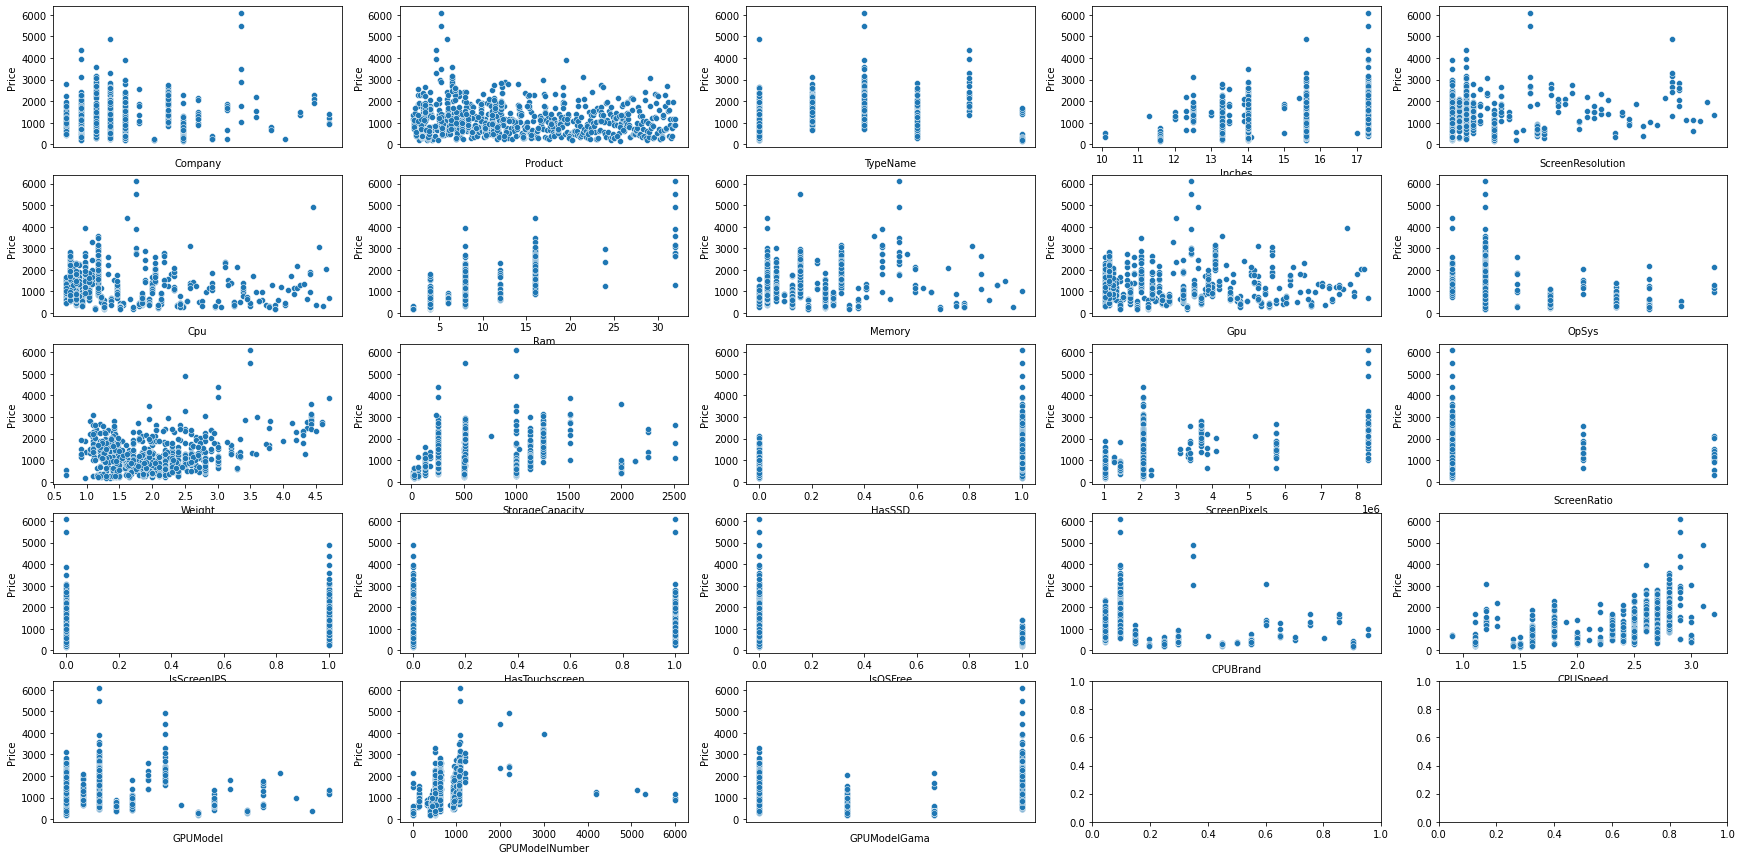

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Relplot
# Scatterplot
# Density plot
# Characteristic line plot

class Draw:
  def __init__(self, model):
    self.model = model
    self.labels = [
        "Company", "Product", "TypeName", "Inches", "ScreenResolution", "Cpu", "Ram", "Memory", "Gpu", "OpSys", "Weight",
        "StorageCapacity", "HasSSD",
        "ScreenPixels", "ScreenRatio", "IsScreenIPS", "HasTouchscreen", "IsOSFree", "CPUBrand", "CPUSpeed", "GPUModel",
        "GPUModelNumber", "GPUModelGama"
    ]

  def get_grid(self, cols, rows, h, w):
      return plt.subplots(rows, cols, figsize=(w, h))

  def histogram(self, labels):
    fig0, axs0 = plt.subplots(ncols=4)
    fig0.set_figwidth(30)
    fig0.set_figheight(5)

    for i, label in enumerate(labels):
      aux = sns.histplot(self.model.X[label], ax=axs0[i])

      aux.set_xticklabels(aux.get_xticklabels(), rotation = 80, horizontalalignment = 'right')

    #plt.show()

  def countplot(self, labels):
    fig0, axs0 = plt.subplots(ncols=4)
    fig0.set_figwidth(30)
    fig0.set_figheight(5)

    for i, label in enumerate(labels):
      aux = sns.countplot(self.model.X[label], ax=axs0[i])

      #aux0.set_xticklabels(aux0.get_xticklabels(), rotation = 85, horizontalalignment = 'right')

      aux.set(xticklabels=label)
      aux.set(xlabel=None)

  def kde(self, labels):
    # El numero de caracteristicas que tienen tipo numerico, para decidir las dimensiones
    n_of_numerical_features = len([ True for f in self.model.X if type(self.model.X[f][0]) != str ])
    
    fig, axs = self.get_grid(rows=n_of_numerical_features//4, cols=4, h=10, w=25)
    fig.delaxes(axs[1][2]) # Elimnar plots vacios
    fig.delaxes(axs[1][3])
    
    i = 0
    for label in labels:
      if type(self.model.X[label][0]) != str:
        sns.kdeplot(self.model.X[label], ax=axs[i//4, i%4])
        i += 1
  
  def relplot(self, labels, hue=None):
    rows, cols = 5, 5
    fig, axs = self.get_grid(rows=rows, cols=cols, h=15, w=30)
    #fig.delaxes(axs[2][3]) # Elimnar plots vacios

    for i, label in enumerate(labels):
      s = sns.scatterplot(data=self.model.X, x=label, y="Price", ax=axs[i//rows, i%rows], hue=hue)

      # Si es una feature con strings, quitar los ticks porque si no no se ve nada
      if type(self.model.X[label][0]) == str:
        s.set(xticklabels=[])  
        s.tick_params(bottom=False)

  def run(self):
    #self.countplot(["ScreenResolution", "Cpu", "Gpu", "Weight"])
    #self.histogram(["ScreenResolution", "Cpu", "Gpu", "Weight"])
    #self.kde(self.labels)
    self.relplot(self.labels)

    #plt.show()

  
draw = Draw(model)
draw.run()